In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
import pandas as pd
import glob
import re

price_folder = "/content/drive/MyDrive/Proyecto API/MonthlyCSV/"
csv_files = sorted(glob.glob(price_folder + "monthly_price_*.csv"))

dfs = []
for f in csv_files:
    match = re.search(r"(\d{8})", f)
    if match:
        date_str = match.group(1)  # ej: '20250401'
        fecha = pd.to_datetime(date_str, format="%Y%m%d")

        df = pd.read_csv(f)
        df["fecha"] = fecha
        dfs.append(df)
    else:
        print(f"⚠️ No se encontró una fecha válida en el nombre de: {f}")

df_prices = pd.concat(dfs, ignore_index=True)



In [30]:
import pandas as pd
import glob
import re

# --- Ruta a tu carpeta de snapshots ---
price_folder = "/content/drive/MyDrive/Proyecto API/MonthlyCSV/"
meta_path    = "/content/drive/MyDrive/Proyecto API/Metadatos Cartas/metadata_cards.csv"

# --- 1. Mostrar columnas de un snapshot de precios ---
csv_files = sorted(glob.glob(price_folder + "*.csv"))

if csv_files:
    df_sample_price = pd.read_csv(csv_files[0])
    print("🧾 Columnas del snapshot de precios:")
    print(df_sample_price.columns.tolist())
else:
    print("❌ No se encontraron archivos CSV en la carpeta de precios.")

# --- 2. Mostrar columnas del CSV de metadatos ---
try:
    df_meta = pd.read_csv(meta_path)
    print("\n📘 Columnas del CSV de metadatos:")
    print(df_meta.columns.tolist())
except FileNotFoundError:
    print(f"❌ No se encontró el archivo de metadatos en: {meta_path}")


🧾 Columnas del snapshot de precios:
['id', 'name', 'supertype', 'subtypes', 'rarity', 'set_id', 'set_name', 'number', 'artist', 'types', 'ancientTrait', 'images_small', 'images_large', 'cardmarket_url', 'cardmarket_updatedAt', 'cm_averageSellPrice', 'cm_lowPrice', 'cm_trendPrice', 'cm_germanProLow', 'cm_suggestedPrice', 'cm_reverseHoloSell', 'cm_reverseHoloLow', 'cm_reverseHoloTrend', 'cm_lowPriceExPlus', 'cm_avg1', 'cm_avg7', 'cm_avg30', 'cm_reverseHoloAvg1', 'cm_reverseHoloAvg7', 'cm_reverseHoloAvg30', 'tcgplayer_url', 'tcgplayer_updatedAt', 'tcg_holofoil_low', 'tcg_holofoil_mid', 'tcg_holofoil_market', 'tcg_reverseHolofoil_low', 'tcg_reverseHolofoil_mid', 'tcg_reverseHolofoil_market', 'tcg_normal_low', 'tcg_normal_mid', 'tcg_normal_market']

📘 Columnas del CSV de metadatos:
['id', 'name', 'supertype', 'subtypes', 'rarity', 'set_id', 'set_name', 'number', 'artist', 'types', 'ancientTrait', 'legalities', 'images_small', 'images_large']


577/577 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


,t0,t1,MAE (€),RMSE (€),N
0,2025-04-01,2025-04-30,8.45,91.09,18462


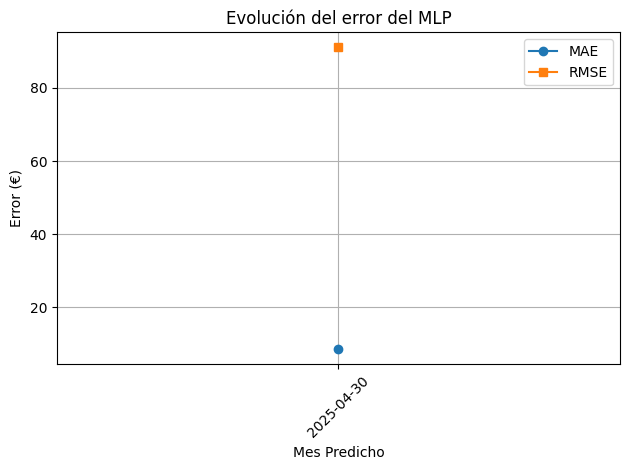

In [41]:
import pandas as pd
import numpy as np
import joblib
import glob
import os
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import TFSMLayer
from tensorflow.keras import Sequential

# --- 📁 Rutas ---
drive_base   = "/content/drive/MyDrive/Proyecto API/RedNeuronal/mlp_v1"
price_folder = "/content/drive/MyDrive/Proyecto API/MonthlyCSV/"
scaler_path  = os.path.join(drive_base, "scaler_mlp_num.pkl")
ohe_path     = os.path.join(drive_base, "ohe_mlp_cat.pkl")
model_path   = drive_base

# --- 🔌 Cargar modelo MLP con TFSMLayer ---
mlp_layer = TFSMLayer(model_path, call_endpoint='serving_default')
model     = Sequential([mlp_layer])

# --- 🧠 Cargar preprocesadores ---
scaler  = joblib.load(scaler_path)
encoder = joblib.load(ohe_path)

# --- 📊 Cargar snapshots ---
csv_files = sorted(glob.glob(price_folder + "monthly_price_*.csv"))
snapshots = []
for f in csv_files:
    m = re.search(r"(\d{8})", f)
    if not m: continue
    fecha = pd.to_datetime(m.group(1), format="%Y%m%d")
    df = pd.read_csv(f)
    df["fecha"] = fecha
    snapshots.append(df)

# --- 📈 Evaluación mes a mes ---
resultados = []
for i in range(len(snapshots) - 1):
    t0, t1 = snapshots[i], snapshots[i+1]
    date_t0, date_t1 = t0["fecha"].iloc[0], t1["fecha"].iloc[0]

    # Merge y limpieza
    merged = pd.merge(
        t0[["id","cm_trendPrice","artist","name","rarity","set_name","types","supertype","subtypes"]],
        t1[["id","cm_averageSellPrice"]],
        on="id", how="inner"
    ).dropna(subset=["cm_trendPrice","cm_averageSellPrice"])
    if len(merged) < 10:
        print(f"⚠️ Pocas muestras para {date_t0.date()}→{date_t1.date()}, salto.")
        continue

    # Renombrar para el encoder
    merged = merged.rename(columns={"artist":"artist_name","name":"pokemon_name"})

    # Numéricas
    merged["price_t0_log"] = np.log1p(merged["cm_trendPrice"])
    merged["days_diff"]    = (date_t1 - date_t0).days
    X_num = scaler.transform(merged[["price_t0_log","days_diff"]])

    # Categóricas
    cat_cols = list(encoder.feature_names_in_)
    X_cat = encoder.transform(merged[cat_cols])

    # Input y target
    X_test = np.hstack([X_num, X_cat])
    y_true = merged["cm_averageSellPrice"].values

    # ───▶️ Predicción CORREGIDA
    y_pred_dict = model.predict(X_test)
    y_pred = list(y_pred_dict.values())[0].flatten()


    # Métricas
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    resultados.append({
        "t0": date_t0.strftime("%Y-%m-%d"),
        "t1": date_t1.strftime("%Y-%m-%d"),
        "MAE (€)" : round(mae,2),
        "RMSE (€)": round(rmse,2),
        "N": len(y_true)
    })

# Mostrar resultados
df_res = pd.DataFrame(resultados)
display(df_res)

# Gráfico
plt.figure()
plt.plot(df_res["t1"], df_res["MAE (€)"], marker='o', label="MAE")
plt.plot(df_res["t1"], df_res["RMSE (€)"], marker='s', label="RMSE")
plt.xticks(rotation=45)
plt.xlabel("Mes Predicho")
plt.ylabel("Error (€)")
plt.title("Evolución del error del MLP")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


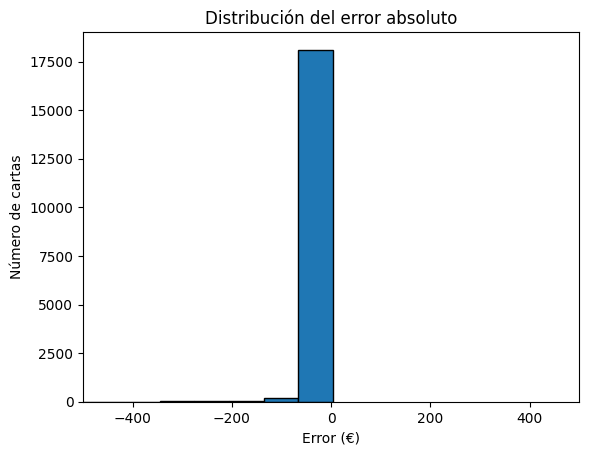

In [42]:
residuals = y_pred - y_true
plt.figure()
plt.hist(residuals, bins=100, edgecolor='k')
plt.xlabel("Error (€)")
plt.ylabel("Número de cartas")
plt.title("Distribución del error absoluto")
plt.xlim(-500, 500)
plt.show()


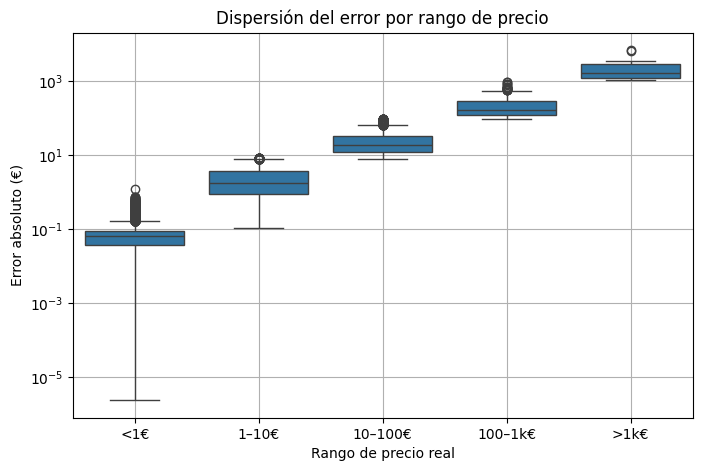

In [43]:
df_err = pd.DataFrame({
    'precio_real': y_true,
    'error': np.abs(residuals)
})
df_err['rango'] = pd.cut(df_err['precio_real'], bins=[0,1,10,100,1000,1e5],
                         labels=["<1€", "1–10€", "10–100€", "100–1k€", ">1k€"])

import seaborn as sns
plt.figure(figsize=(8,5))
sns.boxplot(data=df_err, x="rango", y="error")
plt.yscale("log")
plt.title("Dispersión del error por rango de precio")
plt.ylabel("Error absoluto (€)")
plt.xlabel("Rango de precio real")
plt.grid(True)
plt.show()


In [50]:
# Top 10 por error absoluto
top_abs = df_errores.sort_values("error_abs", ascending=False).head(10)[
    ["nombre", "precio_real", "prediccion", "error_abs"]
].rename(columns={
    "precio_real": "precio_real_abs",
    "prediccion": "prediccion_abs",
    "error_abs": "error_abs (€)"
})

# Top 10 por error relativo
top_rel = df_errores[df_errores["precio_real"] > 1].sort_values("error_rel_%", ascending=False).head(10)[
    ["nombre", "precio_real", "prediccion", "error_rel_%"]
].rename(columns={
    "precio_real": "precio_real_rel",
    "prediccion": "prediccion_rel",
    "error_rel_%": "error_relativo (%)"
})

# Combinar (outer join por nombre para mantener nombres distintos en ambos rankings)
df_comb = pd.merge(top_abs, top_rel, on="nombre", how="outer")

# Mostrar tabla final
import pandas as pd
from IPython.display import display
display(df_comb)



,nombre,precio_real_abs,prediccion_abs,error_abs (€),precio_real_rel,prediccion_rel,error_relativo (%)
0,Champions Festival,NaN,NaN,NaN,60.00,0.166973,99.721710
1,Charizard,6986.67,3.765712,6982.904288,6986.67,3.765712,99.946101
2,Espeon ★,6499.00,4.633709,6494.366291,6499.00,4.633709,99.928701
3,Groudon ★,2712.50,5.481597,2707.018403,2712.50,5.481597,99.797913
4,Latias & Latios-GX,1650.16,3.736743,1646.423257,1650.16,3.736743,99.773553
5,Mewtwo ★,1264.75,4.667735,1260.082265,NaN,NaN,NaN
6,Mudkip ★,1700.00,5.544880,1694.455120,1700.00,5.544880,99.673831
7,Rayquaza ★,2250.00,4.505240,2245.494760,2250.00,4.505240,99.799767
8,Torchic ★,1792.25,5.343153,1786.906847,1792.25,5.343153,99.701874
9,Umbreon VMAX,1229.55,3.468165,1226.081835,1229.55,3.468165,99.717932


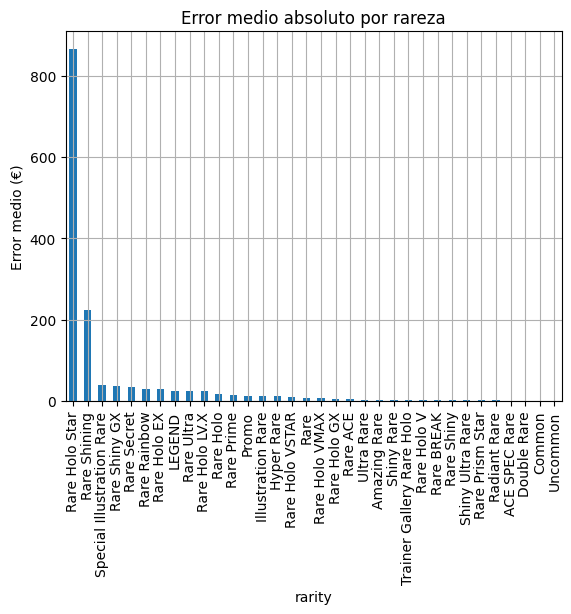

In [48]:
df_rareza = merged.copy()
df_rareza["error"] = np.abs(y_pred - y_true)
df_rareza.groupby("rarity")["error"].mean().sort_values(ascending=False).plot(kind='bar')
plt.ylabel("Error medio (€)")
plt.title("Error medio absoluto por rareza")
plt.grid(True)
plt.show()


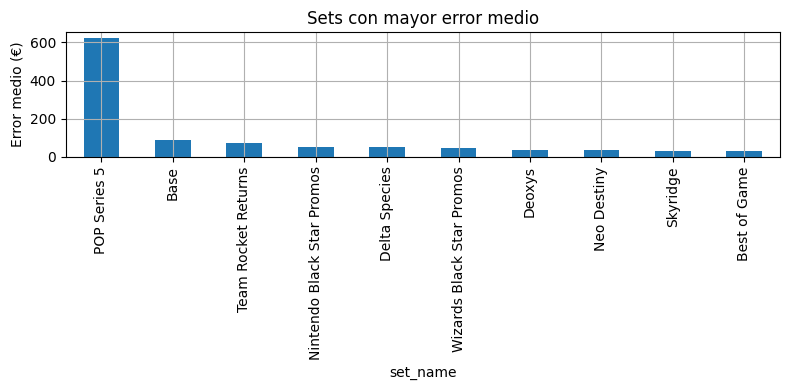

In [49]:
df_set = merged.copy()
df_set["error"] = np.abs(y_pred - y_true)
top_sets = df_set.groupby("set_name")["error"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,4))
top_sets.plot(kind='bar')
plt.title("Sets con mayor error medio")
plt.ylabel("Error medio (€)")
plt.grid(True)
plt.tight_layout()
plt.show()


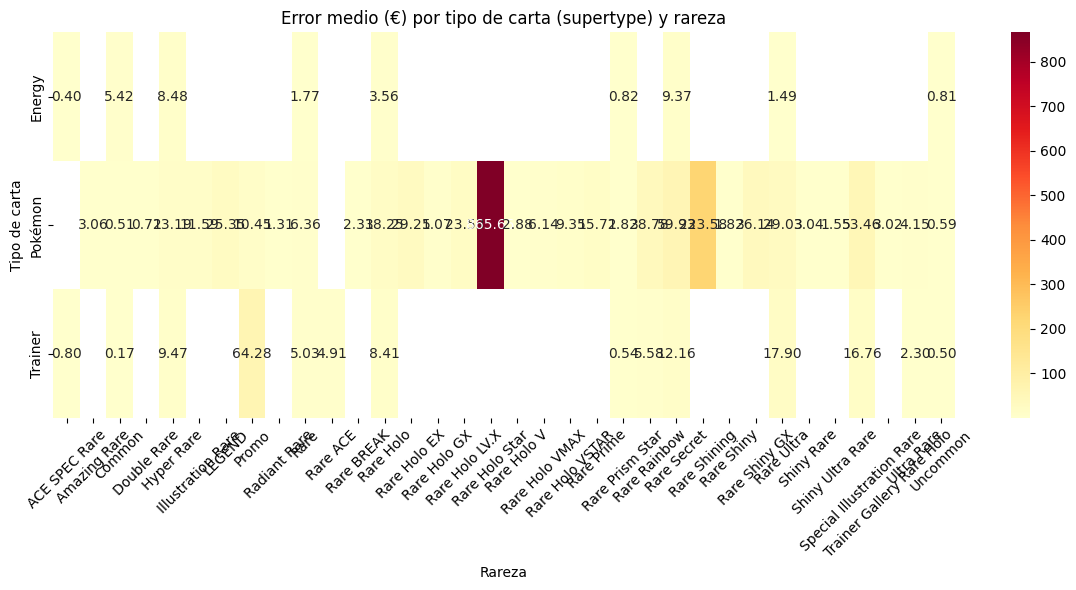

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

df_heatmap = merged.copy()
df_heatmap["error"] = np.abs(y_pred - y_true)

pivot = df_heatmap.pivot_table(
    index="supertype", columns="rarity", values="error", aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Error medio (€) por tipo de carta (supertype) y rareza")
plt.ylabel("Tipo de carta")
plt.xlabel("Rareza")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


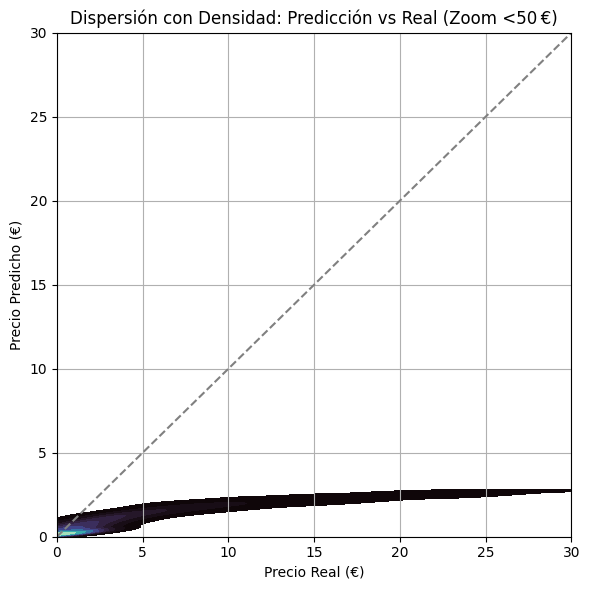

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar aún más los precios que están por debajo de 50 €
mask = (y_true < 50) & (y_pred < 50)
y_true_clip = y_true[mask]
y_pred_clip = y_pred[mask]

plt.figure(figsize=(6,6))
sns.kdeplot(x=y_true_clip, y=y_pred_clip, fill=True, cmap="mako", thresh=0.05)
plt.plot([0, 30], [0, 30], linestyle='--', color='gray')
plt.xlim(0, 30)
plt.ylim(0, 30)
plt.xlabel("Precio Real (€)")
plt.ylabel("Precio Predicho (€)")
plt.title("Dispersión con Densidad: Predicción vs Real (Zoom <50 €)")
plt.grid(True)
plt.tight_layout()
plt.show()



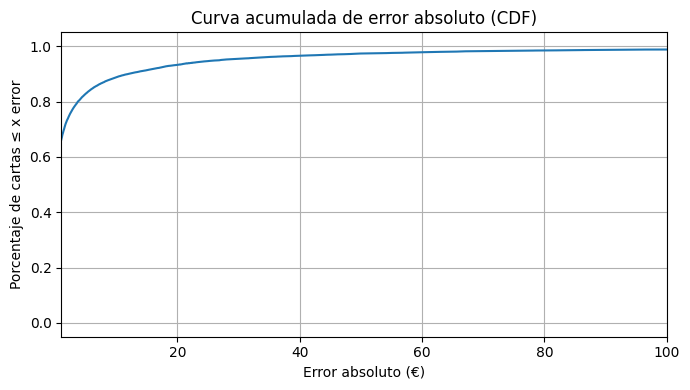

In [58]:
residuals_abs = np.abs(y_pred - y_true)
res_sorted = np.sort(residuals_abs)
cdf = np.arange(len(res_sorted)) / len(res_sorted)

plt.figure(figsize=(7,4))
plt.plot(res_sorted, cdf, label="CDF")
plt.xlim(1, 100)  # 🔽 Limitar visualización a errores entre 0 y 1000 €
plt.xlabel("Error absoluto (€)")
plt.ylabel("Porcentaje de cartas ≤ x error")
plt.title("Curva acumulada de error absoluto (CDF)")
plt.grid(True)
plt.tight_layout()
plt.show()



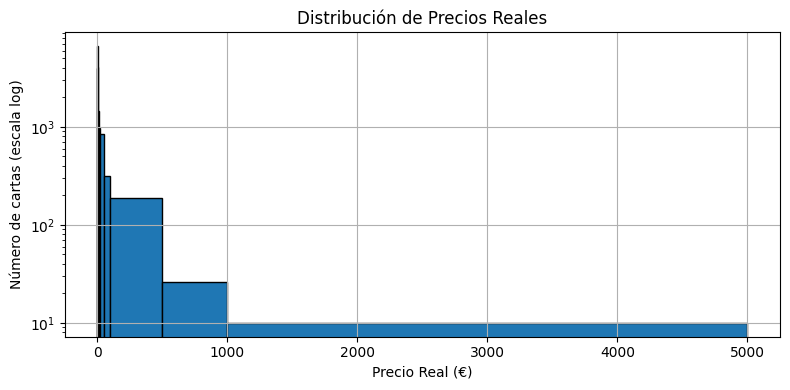

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Suponemos que y_true y y_pred ya existen en el entorno

# Simular df_errores si no existe
df_errores = pd.DataFrame({
    "precio_real": y_true,
    "prediccion": y_pred
})
df_errores["error_abs"] = np.abs(df_errores["precio_real"] - df_errores["prediccion"])
df_errores["error_rel_%"] = 100 * df_errores["error_abs"] / (df_errores["precio_real"] + 1e-6)

# 1️⃣ Histograma de precios reales
plt.figure(figsize=(8, 4))
bins = [0, 0.1, 1, 5, 10, 20, 50, 100, 500, 1000, 5000]
plt.hist(df_errores["precio_real"], bins=bins, edgecolor='k', log=True)
plt.xlabel("Precio Real (€)")
plt.ylabel("Número de cartas (escala log)")
plt.title("Distribución de Precios Reales")
plt.grid(True)
plt.tight_layout()
plt.show()

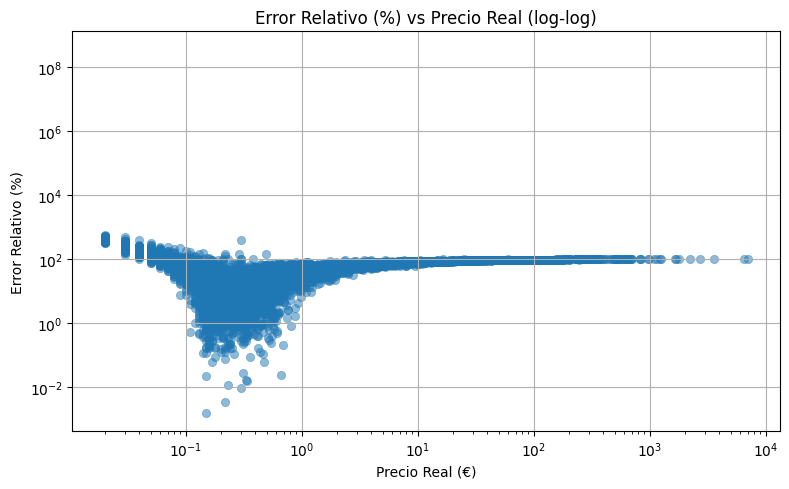

In [65]:
# 4️⃣ Gráfico de dispersión precio real vs error relativo, coloreado por rareza si existe
if "rarity" in df.columns:
    df_errores["rarity"] = df["rarity"].values
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x="precio_real", y="error_rel_%", hue="rarity",
        data=df_errores, alpha=0.6, edgecolor=None
    )
else:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x="precio_real", y="error_rel_%", data=df_errores,
        alpha=0.5, edgecolor=None
    )

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Precio Real (€)")
plt.ylabel("Error Relativo (%)")
plt.title("Error Relativo (%) vs Precio Real (log-log)")
plt.grid(True)
plt.tight_layout()
plt.show()